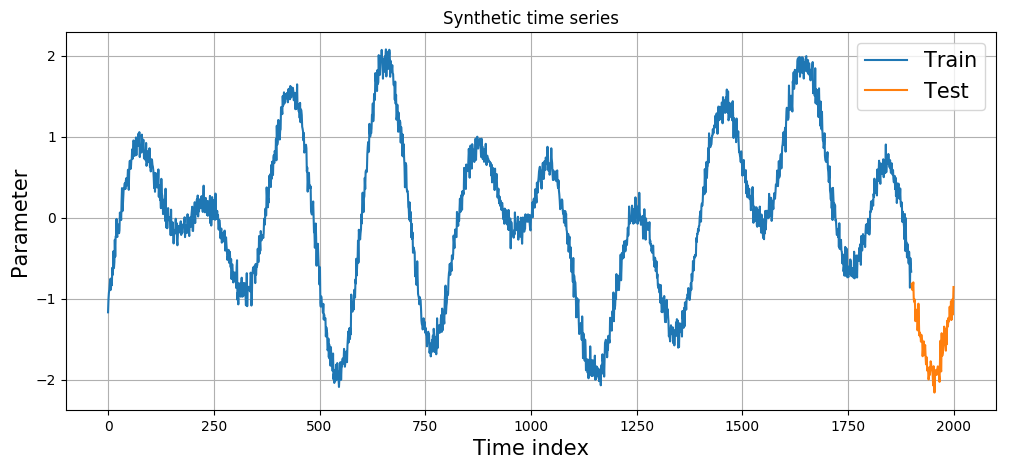

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def generate_synthetic_data(length: int = 2000, periods: int = 10):
    """
    The function generates a synthetic univariate time series

    :param length: the length of the array (even number)
    :param periods: the number of periods in the sine wave

    :return synthetic_data: an array without gaps
    """

    # First component
    sinusoidal_data = np.linspace(-periods * np.pi, periods * np.pi, length)
    sinusoidal_data = np.sin(sinusoidal_data)
    
    # Second component
    cos_1_data = np.linspace(-periods * np.pi/2, periods/2 * np.pi/2, int(length/2))
    cos_1_data = np.cos(cos_1_data) 
    cos_2_data = np.linspace(periods/2 * np.pi/2, periods * np.pi/2, int(length/2))
    cos_2_data = np.cos(cos_2_data)   
    cosine_data = np.hstack((cos_1_data, cos_2_data))
    
    random_noise = np.random.normal(loc=0.0, scale=0.1, size=length)

    # Combining a sine wave, cos wave and random noise
    synthetic_data = sinusoidal_data + cosine_data + random_noise
    return synthetic_data

# Get such numpy array
synthetic_time_series = generate_synthetic_data()

# We will predict 100 values in the future
len_forecast = 100

# Let's dividide our data on train and test samples
train_data = synthetic_time_series[:-len_forecast]
test_data = synthetic_time_series[-len_forecast:]

# Plot time series
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(np.arange(0, len(train_data)), train_data, label = 'Train')
plt.plot(np.arange(len(train_data), len(train_data)+len(test_data)), test_data, label = 'Test')
plt.ylabel('Parameter', fontsize = 15)
plt.xlabel('Time index', fontsize = 15)
plt.legend(fontsize = 15)
plt.title('Synthetic time series')
plt.grid()
plt.show()

## 匯出 CSV

In [8]:
import pandas

df = pandas.DataFrame(train_data, columns=['value'])
index = []
y = 2000
m = 1
for i in range(len(df)):
    index.append('%d-%02d' % (y, m))
    m += 1
    if m > 12:
        y += 1
        m = 1

df.index = index
df.to_csv("synthetic_time_series_train.csv")

# --------------------------------------------------

df = pandas.DataFrame(test_data, columns=['value'])
index = []
for i in range(len(df)):
    index.append('%d-%02d' % (y, m))
    m += 1
    if m > 12:
        y += 1
        m = 1
        
df.index = index
df.to_csv("synthetic_time_series_test.csv")

## [AR] Simple AutoRegression

In [7]:
import pandas
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier

class simple_autoregression:
    def __init__(self, window_size, model = LinearRegression):
        self.window_size = window_size
        self.model = model()
        self.lagged_df = None
        
    def train(self, df):
        ws = self.window_size
        
        # generates lagged dataframe
        lagged_df = []
        for s in range(ws, -1, -1):
            lagged_df.append(df.shift(s))
        lagged_df = pandas.concat(lagged_df, axis=1)

        # fill in the column names
        X_columns = []
        for s in range(ws, 0, -1):
            X_columns.append('shift-' + str(s))
        y_column = ['target']
        lagged_df.columns = X_columns + y_column

        # drop na rows (the first `shift_size` rows)
        lagged_df.dropna(inplace = True)
        
        self.model.fit(lagged_df[X_columns], lagged_df[y_column])
        self.lagged_df = lagged_df
        return self
    
    def predict(self, next_steps=1):
        rows, cols = self.lagged_df.shape
        future_df = pandas.DataFrame(columns=self.lagged_df.columns)

        # the first step
        X = self.lagged_df['target'][rows - cols + 1 : rows + 1].to_list()
        y = [self.model.predict([X]).ravel()[0]]
        future_df.loc[0] = X + y
        
        # the last `next_steps-1` steps
        for step in range(next_steps - 1):
            X = future_df.loc[step][1:].to_list()
            y = [self.model.predict([X]).ravel()[0]]
            future_df.loc[step+1] = X + y
        return future_df

    def get_fitted_target(self):
        if self.lagged_df is None:
            raise Exception('Please call the train() API first.')
        
        feature_columns = list(self.lagged_df.columns)
        feature_columns.remove('target')
        fitted_target = self.model.predict(self.lagged_df[feature_columns])
        fitted_target = fitted_target.ravel()
        return fitted_target


## [AR] Find the best training result

In [10]:
from sklearn.metrics import r2_score, mean_squared_error

df_train = pandas.DataFrame(train_data, columns=['value'])
df_metrics = pandas.DataFrame(columns=['window-size', 'train-r2', 'train-rmse', 'test-r2', 'test-rmse'])
metrics = None

for window_size in range(25, 600, 25):
    ar_model = simple_autoregression(window_size)
    ar_model.train(df_train)

    metrics = [window_size]
    
    y_train = ar_model.get_fitted_target()
    y_true = train_data[-len(y_train):]
    score = r2_score(y_true, y_train)
    metrics.append(score)
    score = mean_squared_error(y_true, y_train, squared=False)
    metrics.append(score)

    y_pred = ar_model.predict(next_steps=100).target
    y_true = test_data
    score = r2_score(y_true, y_pred)
    metrics.append(score)
    score = mean_squared_error(y_true, y_pred, squared=False)
    metrics.append(score)
    
    df_metrics.loc[len(df_metrics)] = metrics
    
display(df_metrics)

,window-size,train-r2,train-rmse,test-r2,test-rmse
0,25.0,0.986950,0.108248,-2.632949,0.654725
1,50.0,0.987525,0.106472,-1.168560,0.505842
2,75.0,0.988012,0.104583,-0.076898,0.356465
3,100.0,0.988261,0.103720,-0.186767,0.374207
4,125.0,0.988629,0.102604,0.246130,0.298248
5,150.0,0.989088,0.101206,0.466214,0.250965
6,175.0,0.989460,0.100157,-0.293932,0.390738
7,200.0,0.989650,0.099962,-0.578696,0.431597
8,225.0,0.989908,0.099426,-0.218900,0.379239
9,250.0,0.990332,0.098028,0.367644,0.273156


## [AR] Use the best model to predict

In [104]:
window_size = 525
ar_model = simple_autoregression(window_size)
ar_model.train(df_train)

y_pred = ar_model.predict(next_steps=100).target
y_true = test_data

print('test:')
print(' - R2:', round(r2_score(y_true, y_pred), 6))
print(' - MSE:', round(mean_squared_error(y_true, y_pred, squared=True), 6))
print(' - RMSE:', round(mean_squared_error(y_true, y_pred, squared=False), 6))

print(list(y_pred))

test:
 - R2: 0.65138
 - MSE: 0.041135
 - RMSE: 0.202818
[-0.8697726643659095, -0.8375590223083503, -0.7806135426020586, -0.777598877971196, -0.9248212986911728, -1.0033752611961952, -1.0145618287273956, -0.9567816132868584, -1.087077688531444, -1.1773742229993192, -1.0986623175222006, -1.1311327328627325, -1.1594786311896208, -1.1832093928607315, -1.2448359339213122, -1.2476299933424655, -1.408605356510413, -1.264005192684725, -1.5324861998963433, -1.4313224140457652, -1.559551530674495, -1.4562360677826909, -1.5036305465909008, -1.66777435968539, -1.6402488378764442, -1.431697936444789, -1.545771973299326, -1.6928429932795102, -1.595517404663239, -1.7673191596308204, -1.670706220230533, -1.8470216151225245, -1.7085038738135736, -1.7214835513874276, -1.7703707647897595, -2.015268081943805, -1.8321114771078093, -1.8495915846243418, -1.8634569176211189, -1.9439238036384472, -1.9200648387689911, -1.902553698275836, -1.9315114024919162, -1.9368995490020855, -2.0409968003976777, -1.92470593

## FEDOT / AutoML

In [79]:
from fedot.api.main import Task, TaskTypesEnum, DataTypesEnum, InputData
from fedot.api.main import Fedot, TsForecastingParams

fit_data = InputData(
    task=Task(TaskTypesEnum.ts_forecasting), 
    data_type=DataTypesEnum.ts, 
    idx=range(0, len(train_data)), 
    features=train_data, 
    target=train_data
)

auto_model = Fedot(
    problem="ts_forecasting", 
    task_params=TsForecastingParams(forecast_length=100),
    timeout=10 # 10min
)
pipeline = auto_model.fit(fit_data)

Composition started. Parameters tuning: True. Set of candidate models: ['adareg', 'ar', 'catboostreg', 'dtreg', 'gbr', 'lasso', 'lgbmreg', 'linear', 'rfr', 'ridge', 'sgdr', 'stl_arima', 'svr', 'treg', 'xgbreg', 'scaling', 'normalization', 'pca', 'poly_features', 'ransac_lin_reg', 'ransac_non_lin_reg', 'rfe_lin_reg', 'rfe_non_lin_reg', 'lagged', 'sparse_lagged', 'smoothing', 'gaussian_filter']. Composing time limit: 10 min
Pipeline composition started


/home/diatango_lin/tj_tsai/workspace/infra/ml_scikit/env-0719/lib/python3.6/site-packages/fedot/core/repository/operation_types_repository.py:187: UserWarning: Operation scaling not found in the repository
  warnings.warn(f'Operation {operation_id} not found in the repository')
/home/diatango_lin/tj_tsai/workspace/infra/ml_scikit/env-0719/lib/python3.6/site-packages/fedot/core/repository/operation_types_repository.py:187: UserWarning: Operation normalization not found in the repository
  warnings.warn(f'Operation {operation_id} not found in the repository')
/home/diatango_lin/tj_tsai/workspace/infra/ml_scikit/env-0719/lib/python3.6/site-packages/fedot/core/repository/operation_types_repository.py:187: UserWarning: Operation pca not found in the repository
  warnings.warn(f'Operation {operation_id} not found in the repository')
/home/diatango_lin/tj_tsai/workspace/infra/ml_scikit/env-0719/lib/python3.6/site-packages/fedot/core/repository/operation_types_repository.py:187: UserWarning: O

The pipeline saved in the path: /home/diatango_lin/Fedot/composing_history/0/4e80e7bc-9f66-45f2-a45b-d321860d52f0/4e80e7bc-9f66-45f2-a45b-d321860d52f0.json.
The pipeline saved in the path: /home/diatango_lin/Fedot/composing_history/0/973aeb4f-37fa-4f79-a8a7-86cbf563a6f6/973aeb4f-37fa-4f79-a8a7-86cbf563a6f6.json.
The pipeline saved in the path: /home/diatango_lin/Fedot/composing_history/0/f8f10f40-ad6b-4af1-a490-d709142b0dd9/f8f10f40-ad6b-4af1-a490-d709142b0dd9.json.
The pipeline saved in the path: /home/diatango_lin/Fedot/composing_history/0/d6606f1a-732b-442f-8f81-1fe3d1fdad55/d6606f1a-732b-442f-8f81-1fe3d1fdad55.json.
The pipeline saved in the path: /home/diatango_lin/Fedot/composing_history/0/f7f271a3-81c7-4ff4-99b6-be1e02b0a1ee/f7f271a3-81c7-4ff4-99b6-be1e02b0a1ee.json.
The pipeline saved in the path: /home/diatango_lin/Fedot/composing_history/0/1c38a183-c85a-4439-bb93-46accd58f227/1c38a183-c85a-4439-bb93-46accd58f227.json.
The pipeline saved in the path: /home/diatango_lin/Fedot/c

/home/diatango_lin/tj_tsai/workspace/infra/ml_scikit/env-0719/lib/python3.6/site-packages/fedot/core/repository/operation_types_repository.py:187: UserWarning: Operation ridge not found in the repository
  warnings.warn(f'Operation {operation_id} not found in the repository')
/home/diatango_lin/tj_tsai/workspace/infra/ml_scikit/env-0719/lib/python3.6/site-packages/fedot/core/repository/operation_types_repository.py:187: UserWarning: Operation ridge not found in the repository
  warnings.warn(f'Operation {operation_id} not found in the repository')
/home/diatango_lin/tj_tsai/workspace/infra/ml_scikit/env-0719/lib/python3.6/site-packages/fedot/core/repository/operation_types_repository.py:187: UserWarning: Operation ridge not found in the repository
  warnings.warn(f'Operation {operation_id} not found in the repository')
/home/diatango_lin/tj_tsai/workspace/infra/ml_scikit/env-0719/lib/python3.6/site-packages/fedot/core/repository/operation_types_repository.py:187: UserWarning: Operation

The pipeline saved in the path: /home/diatango_lin/Fedot/composing_history/1/93afca64-5bf3-4314-8a10-173f4ba7fbac/93afca64-5bf3-4314-8a10-173f4ba7fbac.json.
The pipeline saved in the path: /home/diatango_lin/Fedot/composing_history/1/4d6bb7c0-82aa-4aa5-af1c-2acbe7031cab/4d6bb7c0-82aa-4aa5-af1c-2acbe7031cab.json.
The pipeline saved in the path: /home/diatango_lin/Fedot/composing_history/1/d52b7f9e-1c7f-48cd-bfb5-b11cff7435b3/d52b7f9e-1c7f-48cd-bfb5-b11cff7435b3.json.
The pipeline saved in the path: /home/diatango_lin/Fedot/composing_history/1/c8313ece-f683-4785-a914-60800a310712/c8313ece-f683-4785-a914-60800a310712.json.
The pipeline saved in the path: /home/diatango_lin/Fedot/composing_history/1/d2f55221-4b0f-4eda-b334-bb5d325475c1/d2f55221-4b0f-4eda-b334-bb5d325475c1.json.
The pipeline saved in the path: /home/diatango_lin/Fedot/composing_history/1/d2f55221-4b0f-4eda-b334-bb5d325475c1/d2f55221-4b0f-4eda-b334-bb5d325475c1.json.
The pipeline saved in the path: /home/diatango_lin/Fedot/c

/home/diatango_lin/tj_tsai/workspace/infra/ml_scikit/env-0719/lib/python3.6/site-packages/fedot/core/repository/operation_types_repository.py:187: UserWarning: Operation ridge not found in the repository
  warnings.warn(f'Operation {operation_id} not found in the repository')
/home/diatango_lin/tj_tsai/workspace/infra/ml_scikit/env-0719/lib/python3.6/site-packages/fedot/core/repository/operation_types_repository.py:187: UserWarning: Operation svr not found in the repository
  warnings.warn(f'Operation {operation_id} not found in the repository')
/home/diatango_lin/tj_tsai/workspace/infra/ml_scikit/env-0719/lib/python3.6/site-packages/fedot/core/repository/operation_types_repository.py:187: UserWarning: Operation linear not found in the repository
  warnings.warn(f'Operation {operation_id} not found in the repository')
/home/diatango_lin/tj_tsai/workspace/infra/ml_scikit/env-0719/lib/python3.6/site-packages/fedot/core/repository/operation_types_repository.py:187: UserWarning: Operation 

The pipeline saved in the path: /home/diatango_lin/Fedot/composing_history/2/1c78df34-2f72-4e31-b642-89d5b8c22103/1c78df34-2f72-4e31-b642-89d5b8c22103.json.
The pipeline saved in the path: /home/diatango_lin/Fedot/composing_history/2/9a529479-4113-4fd3-bd2b-d1eacf6a80b3/9a529479-4113-4fd3-bd2b-d1eacf6a80b3.json.
The pipeline saved in the path: /home/diatango_lin/Fedot/composing_history/2/30d89f98-9450-4224-928c-2b88d4a58dc4/30d89f98-9450-4224-928c-2b88d4a58dc4.json.
The pipeline saved in the path: /home/diatango_lin/Fedot/composing_history/2/c6e8222f-5aac-4c48-9b88-5b71cd70a2bd/c6e8222f-5aac-4c48-9b88-5b71cd70a2bd.json.
The pipeline saved in the path: /home/diatango_lin/Fedot/composing_history/2/b6bdaeaa-7fd0-4cc6-ab94-d6a8a0db28ff/b6bdaeaa-7fd0-4cc6-ab94-d6a8a0db28ff.json.
The pipeline saved in the path: /home/diatango_lin/Fedot/composing_history/2/4a783f2a-2010-4287-816d-bc64af5e0fb3/4a783f2a-2010-4287-816d-bc64af5e0fb3.json.
The pipeline saved in the path: /home/diatango_lin/Fedot/c

/home/diatango_lin/tj_tsai/workspace/infra/ml_scikit/env-0719/lib/python3.6/site-packages/fedot/core/repository/operation_types_repository.py:187: UserWarning: Operation ridge not found in the repository
  warnings.warn(f'Operation {operation_id} not found in the repository')
/home/diatango_lin/tj_tsai/workspace/infra/ml_scikit/env-0719/lib/python3.6/site-packages/fedot/core/repository/operation_types_repository.py:187: UserWarning: Operation stl_arima not found in the repository
  warnings.warn(f'Operation {operation_id} not found in the repository')
/home/diatango_lin/tj_tsai/workspace/infra/ml_scikit/env-0719/lib/python3.6/site-packages/fedot/core/repository/operation_types_repository.py:187: UserWarning: Operation linear not found in the repository
  warnings.warn(f'Operation {operation_id} not found in the repository')
/home/diatango_lin/tj_tsai/workspace/infra/ml_scikit/env-0719/lib/python3.6/site-packages/fedot/core/repository/operation_types_repository.py:187: UserWarning: Oper

The pipeline saved in the path: /home/diatango_lin/Fedot/composing_history/3/b7335e1a-e089-4f3f-9a58-73a01215b899/b7335e1a-e089-4f3f-9a58-73a01215b899.json.
The pipeline saved in the path: /home/diatango_lin/Fedot/composing_history/3/b7335e1a-e089-4f3f-9a58-73a01215b899/b7335e1a-e089-4f3f-9a58-73a01215b899.json.
The pipeline saved in the path: /home/diatango_lin/Fedot/composing_history/3/c0e7b9ec-4bf9-429b-a72a-9bc10bc3945d/c0e7b9ec-4bf9-429b-a72a-9bc10bc3945d.json.
The pipeline saved in the path: /home/diatango_lin/Fedot/composing_history/3/6baa46bb-89d4-4a8f-bf9c-743051a91363/6baa46bb-89d4-4a8f-bf9c-743051a91363.json.
The pipeline saved in the path: /home/diatango_lin/Fedot/composing_history/3/8a0c9735-9247-42c2-ba57-e5425eeb7742/8a0c9735-9247-42c2-ba57-e5425eeb7742.json.
The pipeline saved in the path: /home/diatango_lin/Fedot/composing_history/3/56b13c60-57c7-4244-ab45-44a58593787a/56b13c60-57c7-4244-ab45-44a58593787a.json.
The pipeline saved in the path: /home/diatango_lin/Fedot/c

/home/diatango_lin/tj_tsai/workspace/infra/ml_scikit/env-0719/lib/python3.6/site-packages/fedot/core/repository/operation_types_repository.py:187: UserWarning: Operation ridge not found in the repository
  warnings.warn(f'Operation {operation_id} not found in the repository')
/home/diatango_lin/tj_tsai/workspace/infra/ml_scikit/env-0719/lib/python3.6/site-packages/fedot/core/repository/operation_types_repository.py:187: UserWarning: Operation ridge not found in the repository
  warnings.warn(f'Operation {operation_id} not found in the repository')
/home/diatango_lin/tj_tsai/workspace/infra/ml_scikit/env-0719/lib/python3.6/site-packages/fedot/core/repository/operation_types_repository.py:187: UserWarning: Operation ridge not found in the repository
  warnings.warn(f'Operation {operation_id} not found in the repository')
/home/diatango_lin/tj_tsai/workspace/infra/ml_scikit/env-0719/lib/python3.6/site-packages/fedot/core/repository/operation_types_repository.py:187: UserWarning: Operation

The pipeline saved in the path: /home/diatango_lin/Fedot/composing_history/4/0fac000b-4544-4594-ac2d-470c1940b42d/0fac000b-4544-4594-ac2d-470c1940b42d.json.
The pipeline saved in the path: /home/diatango_lin/Fedot/composing_history/4/b877e286-76f2-45f5-ac43-70afa6a2ffb4/b877e286-76f2-45f5-ac43-70afa6a2ffb4.json.
The pipeline saved in the path: /home/diatango_lin/Fedot/composing_history/4/5905e0e3-30f2-464f-98d6-0027f903e00c/5905e0e3-30f2-464f-98d6-0027f903e00c.json.
The pipeline saved in the path: /home/diatango_lin/Fedot/composing_history/4/4a3518ee-7831-4661-828c-f6b972aab861/4a3518ee-7831-4661-828c-f6b972aab861.json.
The pipeline saved in the path: /home/diatango_lin/Fedot/composing_history/4/bd462dea-ec9d-4136-ae34-ccd7d66a6565/bd462dea-ec9d-4136-ae34-ccd7d66a6565.json.
The pipeline saved in the path: /home/diatango_lin/Fedot/composing_history/4/88bb008a-bcb0-4401-b957-2cadaee42e4a/88bb008a-bcb0-4401-b957-2cadaee42e4a.json.
The pipeline saved in the path: /home/diatango_lin/Fedot/c

/home/diatango_lin/tj_tsai/workspace/infra/ml_scikit/env-0719/lib/python3.6/site-packages/fedot/core/repository/operation_types_repository.py:187: UserWarning: Operation ridge not found in the repository
  warnings.warn(f'Operation {operation_id} not found in the repository')
/home/diatango_lin/tj_tsai/workspace/infra/ml_scikit/env-0719/lib/python3.6/site-packages/fedot/core/repository/operation_types_repository.py:187: UserWarning: Operation rfr not found in the repository
  warnings.warn(f'Operation {operation_id} not found in the repository')
/home/diatango_lin/tj_tsai/workspace/infra/ml_scikit/env-0719/lib/python3.6/site-packages/fedot/core/repository/operation_types_repository.py:187: UserWarning: Operation linear not found in the repository
  warnings.warn(f'Operation {operation_id} not found in the repository')
/home/diatango_lin/tj_tsai/workspace/infra/ml_scikit/env-0719/lib/python3.6/site-packages/fedot/core/repository/operation_types_repository.py:187: UserWarning: Operation 

The pipeline saved in the path: /home/diatango_lin/Fedot/composing_history/5/01f0b67a-06d4-4407-ba64-aa696cf7cdbb/01f0b67a-06d4-4407-ba64-aa696cf7cdbb.json.
The pipeline saved in the path: /home/diatango_lin/Fedot/composing_history/5/cf407cc9-3c28-49c3-b7a6-8507fe5abc42/cf407cc9-3c28-49c3-b7a6-8507fe5abc42.json.
The pipeline saved in the path: /home/diatango_lin/Fedot/composing_history/5/1929864a-f2ed-429b-9603-00950815055a/1929864a-f2ed-429b-9603-00950815055a.json.
The pipeline saved in the path: /home/diatango_lin/Fedot/composing_history/5/09f1fcd0-eb63-4fa0-b63b-43a810c55a4c/09f1fcd0-eb63-4fa0-b63b-43a810c55a4c.json.
The pipeline saved in the path: /home/diatango_lin/Fedot/composing_history/5/f579ce34-f7d4-4985-8c4d-0b3941f36e16/f579ce34-f7d4-4985-8c4d-0b3941f36e16.json.
The pipeline saved in the path: /home/diatango_lin/Fedot/composing_history/5/4b18f265-f83f-4544-bd93-3e77150e1fb8/4b18f265-f83f-4544-bd93-3e77150e1fb8.json.
The pipeline saved in the path: /home/diatango_lin/Fedot/c

/home/diatango_lin/tj_tsai/workspace/infra/ml_scikit/env-0719/lib/python3.6/site-packages/fedot/core/repository/operation_types_repository.py:187: UserWarning: Operation ridge not found in the repository
  warnings.warn(f'Operation {operation_id} not found in the repository')
/home/diatango_lin/tj_tsai/workspace/infra/ml_scikit/env-0719/lib/python3.6/site-packages/fedot/core/repository/operation_types_repository.py:187: UserWarning: Operation adareg not found in the repository
  warnings.warn(f'Operation {operation_id} not found in the repository')
/home/diatango_lin/tj_tsai/workspace/infra/ml_scikit/env-0719/lib/python3.6/site-packages/fedot/core/repository/operation_types_repository.py:187: UserWarning: Operation linear not found in the repository
  warnings.warn(f'Operation {operation_id} not found in the repository')
/home/diatango_lin/tj_tsai/workspace/infra/ml_scikit/env-0719/lib/python3.6/site-packages/fedot/core/repository/operation_types_repository.py:187: UserWarning: Operati

The pipeline saved in the path: /home/diatango_lin/Fedot/composing_history/6/086d76f1-1299-4d6d-ad66-bd88ac0e450e/086d76f1-1299-4d6d-ad66-bd88ac0e450e.json.
The pipeline saved in the path: /home/diatango_lin/Fedot/composing_history/6/63bf7d70-bc44-4c9d-b0a8-3513bff1916a/63bf7d70-bc44-4c9d-b0a8-3513bff1916a.json.
The pipeline saved in the path: /home/diatango_lin/Fedot/composing_history/6/f264d6df-8480-4982-9ccf-f9d40360b456/f264d6df-8480-4982-9ccf-f9d40360b456.json.
The pipeline saved in the path: /home/diatango_lin/Fedot/composing_history/6/ae21ec31-2eff-42bc-b5f0-b6871c0449b5/ae21ec31-2eff-42bc-b5f0-b6871c0449b5.json.
The pipeline saved in the path: /home/diatango_lin/Fedot/composing_history/6/4579a39b-c064-49f6-abc8-338ad2b2ccd0/4579a39b-c064-49f6-abc8-338ad2b2ccd0.json.
The pipeline saved in the path: /home/diatango_lin/Fedot/composing_history/6/f264d6df-8480-4982-9ccf-f9d40360b456/f264d6df-8480-4982-9ccf-f9d40360b456.json.
The pipeline saved in the path: /home/diatango_lin/Fedot/c

/home/diatango_lin/tj_tsai/workspace/infra/ml_scikit/env-0719/lib/python3.6/site-packages/fedot/core/repository/operation_types_repository.py:187: UserWarning: Operation ridge not found in the repository
  warnings.warn(f'Operation {operation_id} not found in the repository')
/home/diatango_lin/tj_tsai/workspace/infra/ml_scikit/env-0719/lib/python3.6/site-packages/fedot/core/repository/operation_types_repository.py:187: UserWarning: Operation sgdr not found in the repository
  warnings.warn(f'Operation {operation_id} not found in the repository')
/home/diatango_lin/tj_tsai/workspace/infra/ml_scikit/env-0719/lib/python3.6/site-packages/fedot/core/repository/operation_types_repository.py:187: UserWarning: Operation linear not found in the repository
  warnings.warn(f'Operation {operation_id} not found in the repository')
/home/diatango_lin/tj_tsai/workspace/infra/ml_scikit/env-0719/lib/python3.6/site-packages/fedot/core/repository/operation_types_repository.py:187: UserWarning: Operation

The pipeline saved in the path: /home/diatango_lin/Fedot/composing_history/7/f1ced7e6-8507-4f70-aef5-c89cddde4514/f1ced7e6-8507-4f70-aef5-c89cddde4514.json.
The pipeline saved in the path: /home/diatango_lin/Fedot/composing_history/7/b2f0611b-f43c-4d0a-b63d-f4d025f03ac2/b2f0611b-f43c-4d0a-b63d-f4d025f03ac2.json.
The pipeline saved in the path: /home/diatango_lin/Fedot/composing_history/7/19e72bb5-26bc-417a-ac84-4b1f633dde79/19e72bb5-26bc-417a-ac84-4b1f633dde79.json.
The pipeline saved in the path: /home/diatango_lin/Fedot/composing_history/7/a1fd3f0a-5166-454e-aeb1-94c41ceea0b8/a1fd3f0a-5166-454e-aeb1-94c41ceea0b8.json.
The pipeline saved in the path: /home/diatango_lin/Fedot/composing_history/7/4136aee4-f024-4332-94b4-628ab0d969af/4136aee4-f024-4332-94b4-628ab0d969af.json.
The pipeline saved in the path: /home/diatango_lin/Fedot/composing_history/7/c8c5eb80-ea7e-43ad-bc20-f40609098314/c8c5eb80-ea7e-43ad-bc20-f40609098314.json.
The pipeline saved in the path: /home/diatango_lin/Fedot/c

Pipeline structure:
{'depth': 3, 'length': 3, 'nodes': [ridge, lagged, smoothing]}
ridge - {'alpha': 1.3901566994406753}
lagged - {'window_size': 240.83067401974063}
smoothing - {'window_size': 5.245782835729856}


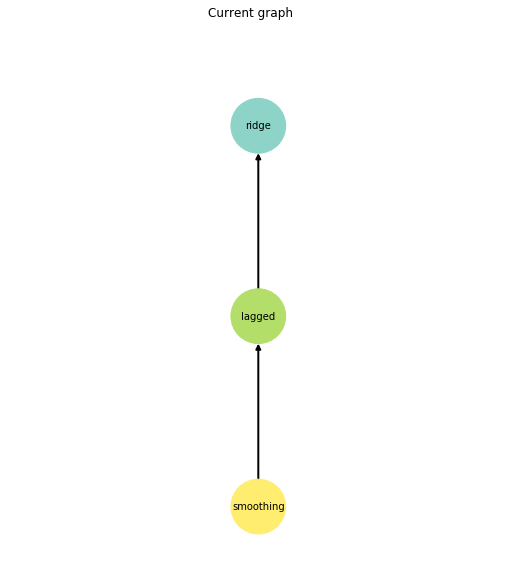

ridge.alpha: {'alpha': 1.3901566994406753}
lagged.window_size: {'window_size': 240.83067401974063}
smoothing.window_size: {'window_size': 5.245782835729856}


In [117]:
# pipeline = auto_model.current_pipeline
pipeline.print_structure()
pipeline.show()

print('ridge.alpha:', auto_model.current_pipeline.nodes[0].custom_params)
print('lagged.window_size:', auto_model.current_pipeline.nodes[1].custom_params)
print('smoothing.window_size:', auto_model.current_pipeline.nodes[2].custom_params)

In [93]:
predict_data = InputData(
    task=Task(TaskTypesEnum.ts_forecasting), 
    data_type=DataTypesEnum.ts, 
    idx=range(len(train_data), len(train_data) + len(test_data)), 
    features=train_data, 
    target=test_data
)
predicted_data = auto_model.predict(predict_data)
predicted_data

array([-0.72620379, -0.75730771, -0.7926196 , -0.8289519 , -0.88412674,
       -0.9442915 , -0.97903428, -0.99349314, -1.04764691, -1.06020068,
       -1.08855625, -1.11498432, -1.17519573, -1.16525244, -1.22559871,
       -1.24873451, -1.29881518, -1.30794215, -1.36581093, -1.3768641 ,
       -1.4262017 , -1.42598458, -1.4607215 , -1.49429301, -1.5029527 ,
       -1.50711444, -1.53015018, -1.57495356, -1.57970592, -1.61038174,
       -1.619313  , -1.66452244, -1.6539955 , -1.6931032 , -1.7106033 ,
       -1.73682275, -1.7314671 , -1.77072715, -1.75282795, -1.76723615,
       -1.79702984, -1.79797779, -1.78819938, -1.7924213 , -1.80825092,
       -1.783774  , -1.80142317, -1.81104995, -1.81796809, -1.80694728,
       -1.83858845, -1.83958373, -1.82522589, -1.83701775, -1.8425141 ,
       -1.80169112, -1.78126466, -1.77882508, -1.76555734, -1.74846991,
       -1.74887439, -1.7388365 , -1.72575015, -1.70433269, -1.68243142,
       -1.65891033, -1.66086318, -1.63003316, -1.60195707, -1.59

In [92]:
print('FEDOT: metrics:', auto_model.get_metrics(test_data, ['r2', 'rmse']))

from sklearn.metrics import r2_score, mean_squared_error
print('sklearn: r2:', r2_score(test_data, predicted_data))
print('sklearn: rmse:', mean_squared_error(test_data, predicted_data, squared=False))

FEDOT: metrics: {'r2': 0.8005372101991294, 'rmse': 0.1534124106657836}
sklearn: r2: 0.8005372101991294
sklearn: rmse: 0.1534124106657836


## Verify the FEDOT model

In [136]:
from fedot.api.main import PrimaryNode, SecondaryNode, Pipeline

smoothing_node = PrimaryNode('smoothing')
smoothing_node.custom_params = {'window_size': 5.245782835729856}

lagged_node = SecondaryNode('lagged', nodes_from=[smoothing_node])
lagged_node.custom_params = {'window_size': 240.83067401974063}

ridge_node = SecondaryNode('ridge', nodes_from=[lagged_node])
ridge_node.custom_params = {'alpha': 1.3901566994406753}

ridge_pipeline = Pipeline(ridge_node)
ridge_pipeline.fit(fit_data)
predicted_data = ridge_pipeline.predict(predict_data)
predicted_data = predicted_data.predict[0]

print(predicted_data)

[-0.72620379 -0.75730771 -0.7926196  -0.8289519  -0.88412674 -0.9442915
 -0.97903428 -0.99349314 -1.04764691 -1.06020068 -1.08855625 -1.11498432
 -1.17519573 -1.16525244 -1.22559871 -1.24873451 -1.29881518 -1.30794215
 -1.36581093 -1.3768641  -1.4262017  -1.42598458 -1.4607215  -1.49429301
 -1.5029527  -1.50711444 -1.53015018 -1.57495356 -1.57970592 -1.61038174
 -1.619313   -1.66452244 -1.6539955  -1.6931032  -1.7106033  -1.73682275
 -1.7314671  -1.77072715 -1.75282795 -1.76723615 -1.79702984 -1.79797779
 -1.78819938 -1.7924213  -1.80825092 -1.783774   -1.80142317 -1.81104995
 -1.81796809 -1.80694728 -1.83858845 -1.83958373 -1.82522589 -1.83701775
 -1.8425141  -1.80169112 -1.78126466 -1.77882508 -1.76555734 -1.74846991
 -1.74887439 -1.7388365  -1.72575015 -1.70433269 -1.68243142 -1.65891033
 -1.66086318 -1.63003316 -1.60195707 -1.59984107 -1.58865557 -1.56562615
 -1.55881635 -1.55387301 -1.49228625 -1.49577347 -1.43639037 -1.41676971
 -1.40865415 -1.42243116 -1.36801922 -1.37215773 -1.

In [134]:
#print('FEDOT: metrics:', ridge_pipeline.get_metrics(test_data, ['r2', 'rmse']))

from sklearn.metrics import r2_score, mean_squared_error
print('sklearn: r2:', r2_score(test_data, predicted_data))
print('sklearn: rmse:', mean_squared_error(test_data, predicted_data, squared=False))

sklearn: r2: 0.8005372101991294
sklearn: rmse: 0.1534124106657836


## The predicted data

In [94]:
ar_300 = [-0.7644056332292157, -0.7808979875799166, -0.7727792728611852, -0.7915679550725928, -0.9011764232090068, -1.0522051121739209, -0.9782344336918745, -0.9847127101684828, -1.0559264729418218, -1.1216638766172933, -1.0500759100260695, -1.127919196075344, -1.2674392117259978, -1.1499802922550484, -1.2788750535247115, -1.2414752267517544, -1.3959169876484583, -1.2827651014306387, -1.506586804787761, -1.424213933485674, -1.4811393076895267, -1.3988858550038636, -1.5390194433504305, -1.633247058215623, -1.595401684769052, -1.526810539999654, -1.5518095639112495, -1.7357575903774178, -1.6550437131049314, -1.7073941216012847, -1.6753996160885807, -1.7554978601454205, -1.7225280209046157, -1.771295534456283, -1.7845897863388434, -1.8833501811146265, -1.8139317206397365, -1.8881318927771351, -1.8193867061918472, -1.8508195442015982, -1.9561184314898683, -1.913758076410345, -1.906369050059907, -1.8887593068827042, -1.977628748130263, -1.8848461358698572, -1.9559567643350437, -1.9407349916273826, -1.9691778932825104, -1.9390771779872824, -2.004003049099707, -1.9724907678735033, -1.9369686512794353, -2.031285421394421, -2.04968261410264, -1.9482643913424547, -1.9289978338788134, -1.9558596262694259, -1.9474153793478144, -1.9173766580859941, -1.9153601108177891, -1.9491545263805072, -1.903305744156706, -1.8934407289319752, -1.8541386430406672, -1.8140981848719935, -1.8772577721631323, -1.801059955264675, -1.8244355711903095, -1.786232034550276, -1.8134546602264077, -1.741003119846171, -1.7570760259252893, -1.8077122618292658, -1.6776509566034015, -1.7714811848549468, -1.6389349887179145, -1.604633066907828, -1.6323978043392513, -1.6875701537961518, -1.574325098629175, -1.6351468727493843, -1.5703823022580987, -1.5175251764912663, -1.4329462787702194, -1.3855517116587854, -1.3625085046085654, -1.3450793345624101, -1.2838020555002378, -1.3525845006151413, -1.2857462506570867, -1.2275048237733566, -1.2010455380160894, -1.2130174046896671, -1.1235487698795108, -1.0844864585230927, -1.1038470106603209, -0.9760667874870463, -1.0471805627614683, -1.0458426232820688]
ar_525 = [-0.8697726643659095, -0.8375590223083503, -0.7806135426020586, -0.777598877971196, -0.9248212986911728, -1.0033752611961952, -1.0145618287273956, -0.9567816132868584, -1.087077688531444, -1.1773742229993192, -1.0986623175222006, -1.1311327328627325, -1.1594786311896208, -1.1832093928607315, -1.2448359339213122, -1.2476299933424655, -1.408605356510413, -1.264005192684725, -1.5324861998963433, -1.4313224140457652, -1.559551530674495, -1.4562360677826909, -1.5036305465909008, -1.66777435968539, -1.6402488378764442, -1.431697936444789, -1.545771973299326, -1.6928429932795102, -1.595517404663239, -1.7673191596308204, -1.670706220230533, -1.8470216151225245, -1.7085038738135736, -1.7214835513874276, -1.7703707647897595, -2.015268081943805, -1.8321114771078093, -1.8495915846243418, -1.8634569176211189, -1.9439238036384472, -1.9200648387689911, -1.902553698275836, -1.9315114024919162, -1.9368995490020855, -2.0409968003976777, -1.9247059374934952, -1.91883021929882, -2.014057501897274, -1.9970177726728822, -1.9216391483574227, -2.137005654582353, -2.018916181231774, -1.9838405019621608, -2.1374937394447358, -2.113396426822654, -2.080470563732119, -2.029930474792659, -1.9679909305735344, -1.9879769123712174, -2.0073861098862102, -1.9559767222475988, -2.007767187299165, -2.038823938531733, -1.99693236649913, -2.0205096983618387, -2.015410001847184, -1.9644069896441099, -1.883726089664044, -2.050892141689194, -1.8572985063532983, -1.9580715982147114, -1.9869273861117231, -1.826141662955235, -1.9173372954535712, -1.8148495204483601, -1.9985550063487394, -1.8047071085979913, -1.7224684644025072, -1.7943400803777614, -1.8638388398990855, -1.7841989071600057, -1.7174568479802053, -1.752797617886413, -1.670575344169061, -1.623797661443729, -1.595316735922682, -1.6294424538755183, -1.5500235255644168, -1.5456230775239503, -1.668326255496281, -1.4994286214131933, -1.442841843944248, -1.4293357689514739, -1.4677774539644795, -1.2991531929441293, -1.3614544496257301, -1.3196960688847648, -1.2951887142344982, -1.4220039651691425, -1.3337006826663775]
azure_autoarima = [-0.7289095407908857 for i in range(100)]
azure_es = [-0.7401574095587135 for i in range(100)]
fedot_auto = [-0.72620379, -0.75730771, -0.7926196 , -0.8289519 , -0.88412674,
       -0.9442915 , -0.97903428, -0.99349314, -1.04764691, -1.06020068,
       -1.08855625, -1.11498432, -1.17519573, -1.16525244, -1.22559871,
       -1.24873451, -1.29881518, -1.30794215, -1.36581093, -1.3768641 ,
       -1.4262017 , -1.42598458, -1.4607215 , -1.49429301, -1.5029527 ,
       -1.50711444, -1.53015018, -1.57495356, -1.57970592, -1.61038174,
       -1.619313  , -1.66452244, -1.6539955 , -1.6931032 , -1.7106033 ,
       -1.73682275, -1.7314671 , -1.77072715, -1.75282795, -1.76723615,
       -1.79702984, -1.79797779, -1.78819938, -1.7924213 , -1.80825092,
       -1.783774  , -1.80142317, -1.81104995, -1.81796809, -1.80694728,
       -1.83858845, -1.83958373, -1.82522589, -1.83701775, -1.8425141 ,
       -1.80169112, -1.78126466, -1.77882508, -1.76555734, -1.74846991,
       -1.74887439, -1.7388365 , -1.72575015, -1.70433269, -1.68243142,
       -1.65891033, -1.66086318, -1.63003316, -1.60195707, -1.59984107,
       -1.58865557, -1.56562615, -1.55881635, -1.55387301, -1.49228625,
       -1.49577347, -1.43639037, -1.41676971, -1.40865415, -1.42243116,
       -1.36801922, -1.37215773, -1.33701224, -1.26519026, -1.20246299,
       -1.16740586, -1.13383315, -1.0976783 , -1.07015372, -1.07999225,
       -1.05511722, -1.0071093 , -0.99304382, -0.96098048, -0.89525761,
       -0.87807508, -0.8413484 , -0.80098279, -0.79894927, -0.77289019]

## Plot the results (Global view)

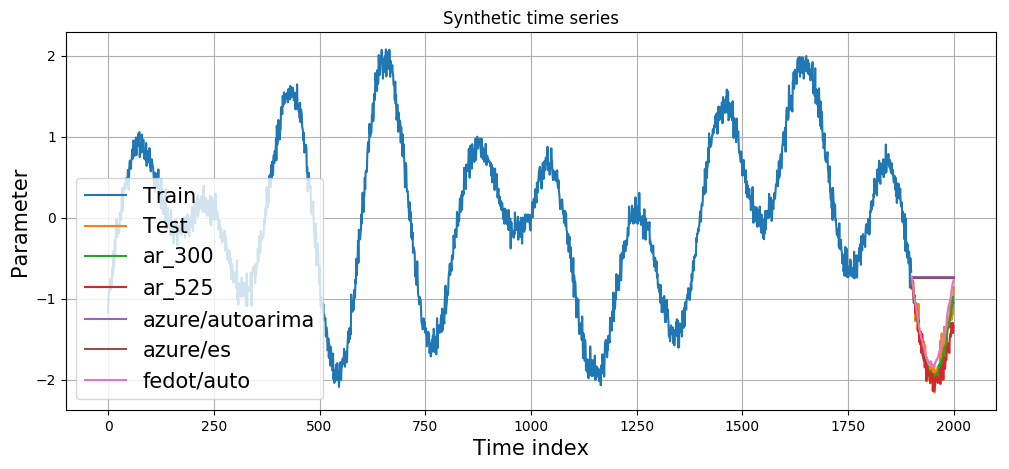

In [101]:
# Plot time series
plt.figure(figsize=(12, 5), dpi=100)

test_start = len(train_data)
test_end = len(train_data) + len(test_data)
plt.plot(np.arange(0, test_start), train_data, label = 'Train') # just show the legend
plt.plot(np.arange(test_start, test_end), test_data, label = 'Test')
plt.plot(np.arange(test_start, test_end), ar_300, label = 'ar_300')
plt.plot(np.arange(test_start, test_end), ar_525, label = 'ar_525')
plt.plot(np.arange(test_start, test_end), azure_autoarima, label = 'azure/autoarima')
plt.plot(np.arange(test_start, test_end), azure_es, label = 'azure/es')
plt.plot(np.arange(test_start, test_end), fedot_auto, label = 'fedot/auto')


plt.ylabel('Parameter', fontsize = 15)
plt.xlabel('Time index', fontsize = 15)
plt.legend(fontsize = 15)
plt.title('Synthetic time series')
plt.grid()
plt.show()

## Plot the results (Testing view)

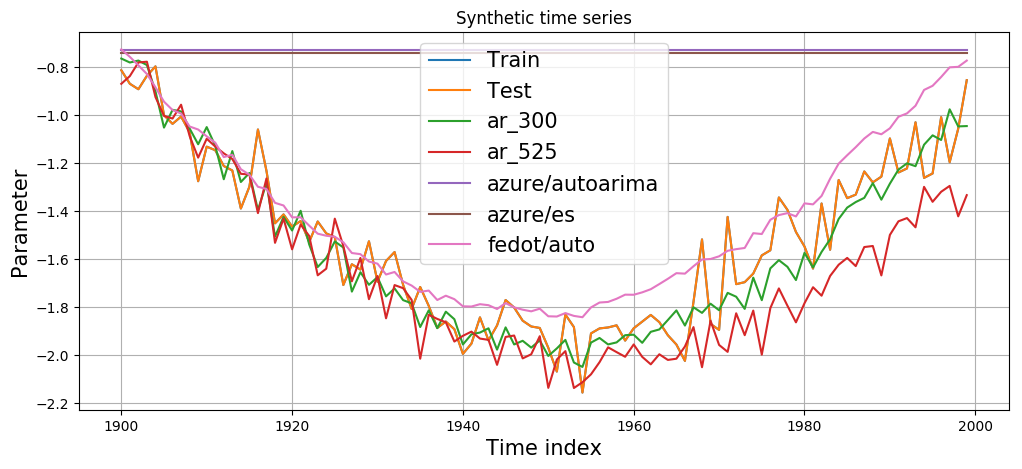

In [98]:
# Plot time series
plt.figure(figsize=(12, 5), dpi=100)

test_start = len(train_data)
test_end = len(train_data) + len(test_data)
plt.plot(np.arange(test_start, test_end), test_data, label = 'Train') # just show the legend
plt.plot(np.arange(test_start, test_end), test_data, label = 'Test')
plt.plot(np.arange(test_start, test_end), ar_300, label = 'ar_300')
plt.plot(np.arange(test_start, test_end), ar_525, label = 'ar_525')
plt.plot(np.arange(test_start, test_end), azure_autoarima, label = 'azure/autoarima')
plt.plot(np.arange(test_start, test_end), azure_es, label = 'azure/es')
plt.plot(np.arange(test_start, test_end), fedot_auto, label = 'fedot/auto')

plt.ylabel('Parameter', fontsize = 15)
plt.xlabel('Time index', fontsize = 15)
plt.legend(fontsize = 15)
plt.title('Synthetic time series')
plt.grid()
plt.show()